In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')

## Modeling functions 

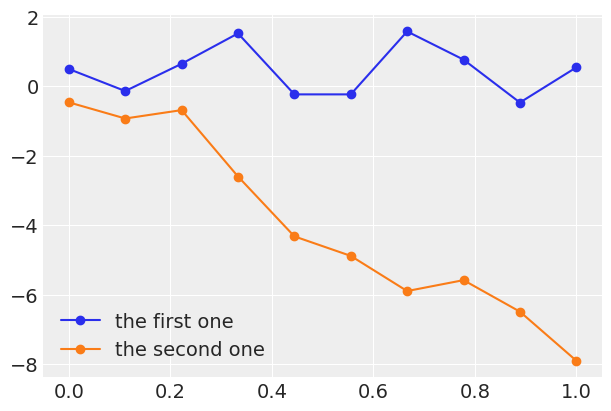

In [3]:
np.random.seed(42)

x = np.linspace(0, 1, 10)
y = np.random.normal(0, 1, len(x))
y2 = np.zeros_like(x)
for i in range(len(x)):
    y2[i] = np.random.normal(y2[i-1], 1)

_, ax = plt.subplots(figsize=(6, 4))

ax.plot(x, y, 'o-', label='the first one')
ax.plot(x, y2, 'o-', label='the second one')
ax.legend()
# plt.savefig('images/ch13/example_g.png')

### Covariance functions and kernels

In [4]:
def exp_quad_kernel(x, knots, ℓ=1):
    """exponentiated quadratic kernel"""
    return np.array([np.exp(-(x-k)**2 / (2*ℓ**2)) for k in knots])

In [5]:
#  def linear_kernel(x, knots):
#      """ linear kernel """
#     return np.array([(x - 2) * (k - 2) for k in knots])

In [6]:
from itertools import product

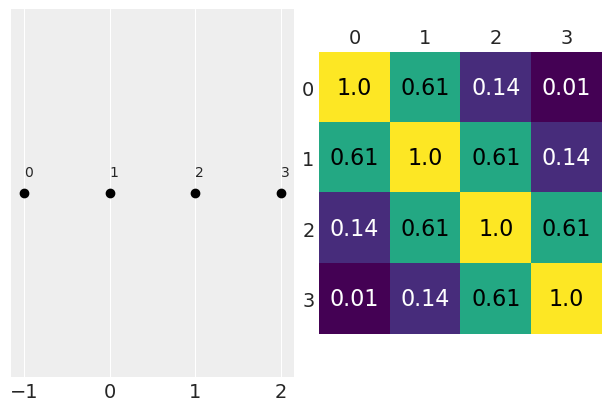

In [7]:
data = np.array([-1, 0, 1, 2])  # np.random.normal(size=4)
cov = exp_quad_kernel(data, data, 1)

_, ax = plt.subplots(1, 2, figsize=(6, 4),  constrained_layout=True)

ax[0].plot(data, np.zeros_like(data), 'ko')
ax[0].set_yticks([])

for idx, i in enumerate(data):
    ax[0].text(i, 0 + 0.005, idx)


ax[1].grid(False)
im = ax[1].imshow(cov)
colors = ['w', 'k']

ls = range(len(data))
prod = product(ls, repeat=2)

for p in prod:
    i, j = p
    ax[1].text(j,
               i,
               round(cov[i, j], 2),
               color=colors[int(im.norm(cov[i, j]) > 0.5)],
               ha='center',
               va='center',
               fontdict={'size': 16})

ax[1].set(xticks=ls, yticks=ls)
ax[1].xaxis.tick_top()

In [8]:
from scipy import stats

Text(-0.03, 0.5, 'f(x)')

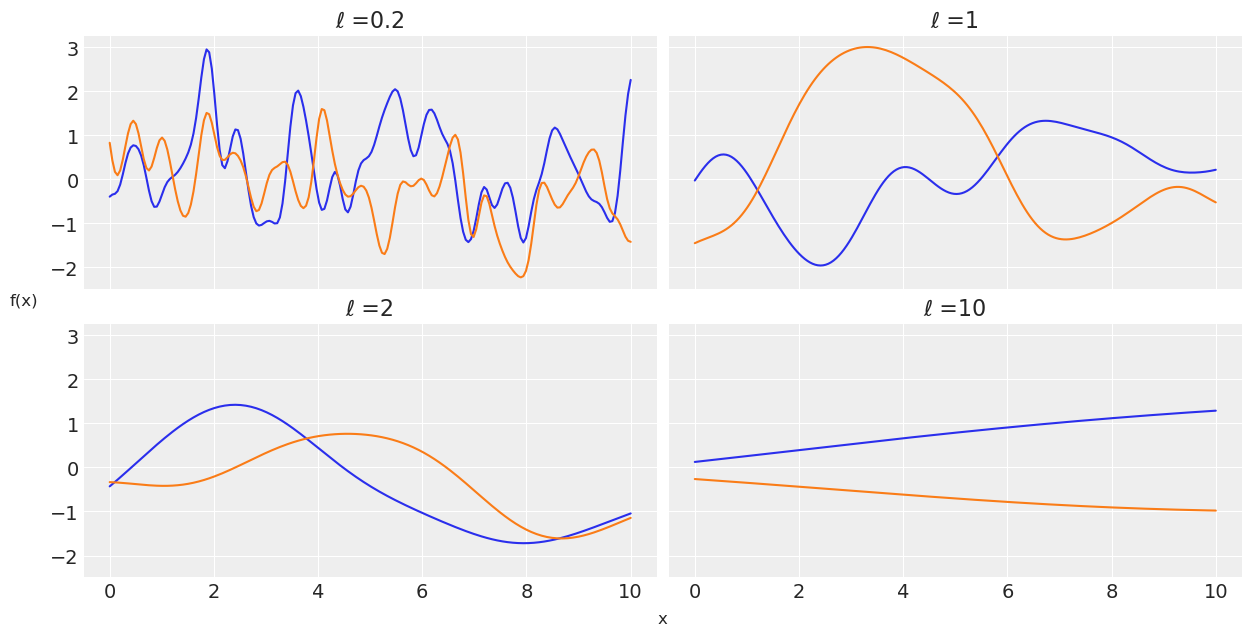

In [9]:
np.random.seed(24)
test_points = np.linspace(0, 10, 200)
fig, axes = plt.subplots(2,
                       2,
                       figsize=(12, 6),
                       sharex=True,
                       sharey=True,
                       constrained_layout=True)



for ℓ, ax in zip((0.2, 1, 2, 10), axes.flatten()):
    cov = exp_quad_kernel(test_points, test_points, ℓ)
    ax.plot(test_points, stats.multivariate_normal.rvs(cov=cov, size=2).T)
    ax.set_title(f'ℓ ={ℓ}')
fig.text(0.51, -0.03, 'x', fontsize='large')
fig.text(-0.03, 0.5, 'f(x)', fontsize='large')

# plt.savefig('images/ch13/kernel_length.png')

## Gaussian Process regression

[Text(0.5, 0, 'x'), Text(0, 0.5, 'f(x)')]

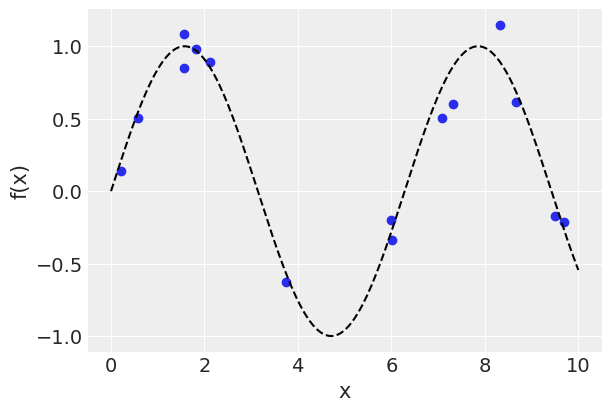

In [10]:
np.random.seed(42)

x = np.random.uniform(0, 10, size=15)
y = np.random.normal(np.sin(x), 0.1)
true_x = np.linspace(0, 10, 200)

_, ax = plt.subplots(figsize=(6, 4))

ax.plot(x, y, 'o')
ax.plot(true_x, np.sin(true_x), 'k--')
ax.set(xlabel='x', ylabel='f(x)')
# plt.savefig('images/ch13/gp_reg.png')

In [11]:
X = x[:, None]

with pm.Model() as model_reg:
    # hyperprior for lengthscale kernel parameter
    ℓ = pm.Gamma('ℓ', 2, 0.5)
    # instanciate a covariance function
    cov = pm.gp.cov.ExpQuad(1, ls=ℓ)
    # instanciate a GP prior
    gp = pm.gp.Marginal(cov_func=cov)
    # prior
    ϵ = pm.HalfNormal('ϵ', 25)
    # likelihood
    y_pred = gp.marginal_likelihood('y_pred', X=X, y=y, noise=ϵ)
    # trace_reg = pm.sample(2000, return_inferencedata=True)
    # trace_reg.to_netcdf("data/ch13/gp_reg.nc")
    trace_reg = az.from_netcdf("../../datasets/pymc/ch13/gp_reg.nc")

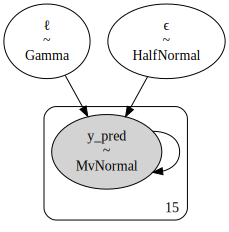

In [12]:
pm.model_to_graphviz(model_reg)

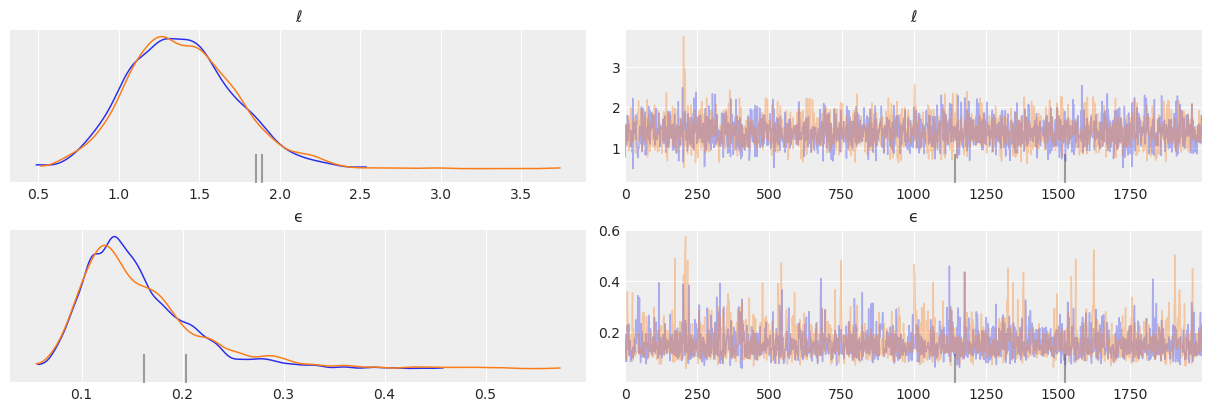

In [13]:
az.plot_trace(trace_reg, compact=False);

In [14]:
X_new = np.linspace(np.floor(x.min()), np.ceil(x.max()), 100)[:,None]

with model_reg:
    # del marginal_gp_model.named_vars['f_pred']
    # marginal_gp_model.vars.remove(f_pred)
    f_pred = gp.conditional('f_pred', X_new)
    pred_samples = pm.sample_posterior_predictive(trace_reg,
                                                  samples=82,
                                                  var_names=['f_pred'])

IncorrectArgumentsError: Should not specify both keep_size and samples arguments. See the docstring of the samples argument for more details.

KeyError: 'f_pred'

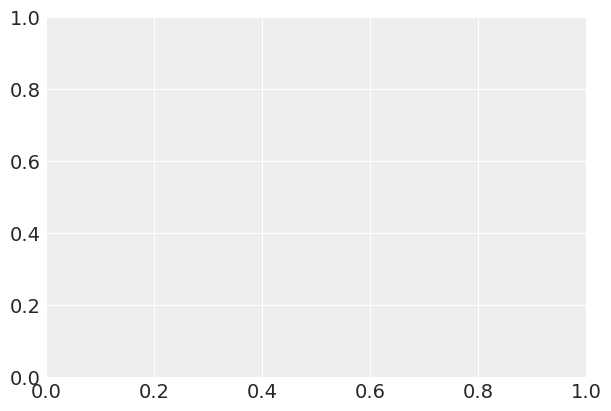

In [ ]:
_, ax = plt.subplots(figsize=(6, 4))

ax.plot(X_new, pred_samples['f_pred'].T, 'C1-', alpha=0.3)
ax.plot(X, y, 'ko')
ax.set(xlabel='X')
# plt.savefig('images/ch13/gp_reg_pred.png')

[Text(0.5, 0, 'x'), Text(0, 0.5, 'f(x)')]

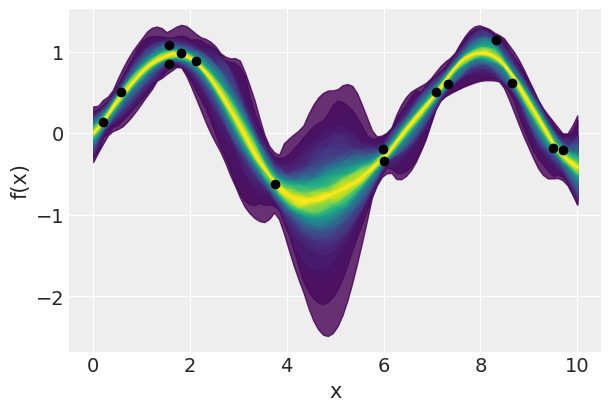

In [ ]:
_, ax = plt.subplots(figsize=(6, 4))

pm.gp.util.plot_gp_dist(ax,
                        pred_samples['f_pred'],
                        X_new,
                        palette='viridis',
                        plot_samples=False)

ax.plot(X, y, 'ko')
ax.set(xlabel='x', ylabel='f(x)')
# plt.savefig('images/ch13/gp_reg_pred_cmap.png')

[Text(0.5, 0, 'X')]

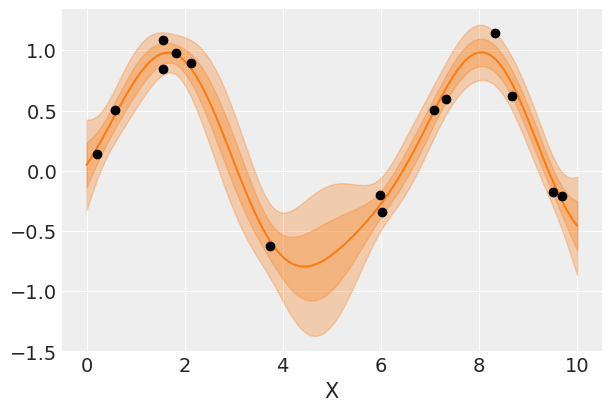

In [ ]:
_, ax = plt.subplots(figsize=(6, 4))

# predict
point = {
    'ℓ': trace_reg.posterior['ℓ'].mean(axis=0).mean(axis=0),
    'ϵ': trace_reg.posterior['ϵ'].mean(axis=0).mean(axis=0),
}

mu, var = gp.predict(X_new, point=point, diag=True)
sd = var**0.5

# plot mean and 1σ and 2σ intervals
ax.plot(X_new, mu, 'C1')
ax.fill_between(X_new.flatten(), mu - sd, mu + sd, color="C1", alpha=0.3)

ax.fill_between(X_new.flatten(),
                mu - 2 * sd,
                mu + 2 * sd,
                color="C1",
                alpha=0.3)

ax.plot(X, y, 'ko')
ax.set(xlabel='X')
# plt.savefig('images/ch13/gp_reg_pred2.png')

## Regression with spatial autocorrelation

In [ ]:
islands_dist = pd.read_csv('../data/islands_dist.csv',
                           sep=',', index_col=0)
islands_dist.round(1)

,Ml,Ti,SC,Ya,Fi,Tr,Ch,Mn,To,Ha
Malekula,0.0,0.5,0.6,4.4,1.2,2.0,3.2,2.8,1.9,5.7
Tikopia,0.5,0.0,0.3,4.2,1.2,2.0,2.9,2.7,2.0,5.3
Santa Cruz,0.6,0.3,0.0,3.9,1.6,1.7,2.6,2.4,2.3,5.4
Yap,4.4,4.2,3.9,0.0,5.4,2.5,1.6,1.6,6.1,7.2
Lau Fiji,1.2,1.2,1.6,5.4,0.0,3.2,4.0,3.9,0.8,4.9
Trobriand,2.0,2.0,1.7,2.5,3.2,0.0,1.8,0.8,3.9,6.7
Chuuk,3.2,2.9,2.6,1.6,4.0,1.8,0.0,1.2,4.8,5.8
Manus,2.8,2.7,2.4,1.6,3.9,0.8,1.2,0.0,4.6,6.7
Tonga,1.9,2.0,2.3,6.1,0.8,3.9,4.8,4.6,0.0,5.0
Hawaii,5.7,5.3,5.4,7.2,4.9,6.7,5.8,6.7,5.0,0.0


In [ ]:
islands = pd.read_csv('../data/islands.csv', sep=',')
islands.head().round(1)

,culture,population,contact,total_tools,mean_TU,lat,lon,lon2,logpop
0,Malekula,1100,low,13,3.2,-16.3,167.5,-12.5,7.0
1,Tikopia,1500,low,22,4.7,-12.3,168.8,-11.2,7.3
2,Santa Cruz,3600,low,24,4.0,-10.7,166.0,-14.0,8.2
3,Yap,4791,high,43,5.0,9.5,138.1,-41.9,8.5
4,Lau Fiji,7400,high,33,5.0,-17.7,178.1,-1.9,8.9


In [ ]:
islands_dist_sqr = islands_dist.values**2
culture_labels = islands['culture'].values
index = islands.index.values
log_pop = islands['logpop']
total_tools = islands['total_tools']
x_data = [islands['lat'].values[:, None], islands['lon'].values[:, None]]

In [ ]:
with pm.Model() as model_islands:
    η = pm.HalfCauchy('η', 1)
    ℓ = pm.HalfCauchy('ℓ', 1)

    cov = η * pm.gp.cov.ExpQuad(1, ls=ℓ)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior('f', X=islands_dist_sqr)

    α = pm.Normal('α', 0, 10)
    β = pm.Normal('β', 0, 1)
    μ = pm.math.exp(α + f[index] + β * log_pop)
    tt_pred = pm.Poisson('tt_pred', μ, observed=total_tools)
    # trace_islands = pm.sample(1000, tune=1000, return_inferencedata=True)
    # trace_islands.to_netcdf("data/ch13/gp_reg_autocorr.nc")
    trace_islands = az.from_netcdf("../../datasets/pymc/ch13/gp_reg_autocorr.nc")

/usr/local/Caskroom/miniconda/base/envs/kaggle/lib/python3.9/site-packages/pymc3/gp/cov.py:92: UserWarning: Only 1 column(s) out of 10 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(


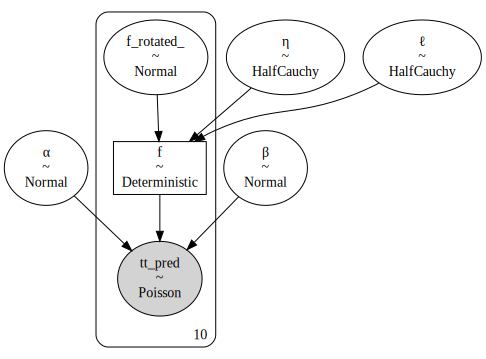

In [ ]:
pm.model_to_graphviz(model_islands)

In [ ]:
az.summary(trace_islands, var_names=['α', 'β', 'η', 'ℓ', 'f'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,0.939,1.173,-1.312,3.093,0.070,0.050,303.0,315.0,1.01
β,0.279,0.123,0.066,0.514,0.007,0.006,310.0,272.0,1.01
η,0.257,0.278,0.001,0.753,0.018,0.013,304.0,323.0,1.01
ℓ,0.897,1.398,0.000,3.018,0.129,0.091,122.0,177.0,1.03
f[0],-0.134,0.363,-0.808,0.540,0.019,0.014,368.0,519.0,1.00
f[1],-0.034,0.333,-0.690,0.556,0.017,0.012,436.0,644.0,1.00
f[2],-0.022,0.309,-0.629,0.543,0.015,0.011,456.0,543.0,1.00
f[3],0.377,0.281,-0.090,0.926,0.013,0.010,500.0,667.0,1.00
f[4],0.063,0.260,-0.429,0.542,0.011,0.009,632.0,696.0,1.00
f[5],-0.303,0.295,-0.853,0.235,0.013,0.009,562.0,588.0,1.00


[(0.0, 1.0),
 Text(0.5, 0, 'distance (thousand kilometers)'),
 Text(0, 0.5, 'covariance')]

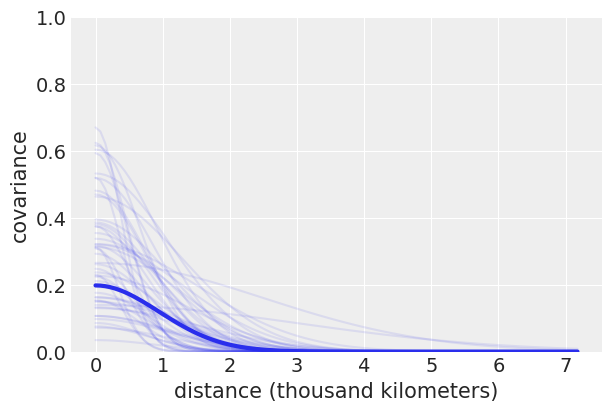

In [ ]:
trace_η = trace_islands.posterior['η'].mean(axis=0).values
trace_ℓ = trace_islands.posterior['ℓ'].mean(axis=0).values

_, ax = plt.subplots(figsize=(6, 4))

xrange = np.linspace(0, islands_dist.values.max(), 100)

ax.plot(xrange,
        np.median(trace_η) * np.exp(-np.median(trace_ℓ) * xrange**2),
        lw=3)

ax.plot(xrange,
        (trace_η[::20][:, np.newaxis] *
         np.exp(-trace_ℓ[::20][:, np.newaxis] * xrange**2)).T,
        'C0',
        alpha=.1)

ax.set(ylim=(0, 1),
       xlabel='distance (thousand kilometers)',
       ylabel='covariance')
# plt.savefig('images/')

In [ ]:
Σ = np.median(trace_η) * (np.exp(-np.median(trace_ℓ) * islands_dist_sqr))
Σ_post = np.diag(np.diag(Σ)**-0.5)

ρ = Σ_post @ Σ @ Σ_post
ρ = pd.DataFrame(ρ, index=islands_dist.columns, columns=islands_dist.columns)
ρ.round(2)

,Ml,Ti,SC,Ya,Fi,Tr,Ch,Mn,To,Ha
Ml,1.00,0.88,0.80,0.00,0.42,0.10,0.00,0.01,0.14,0.0
Ti,0.88,1.00,0.95,0.00,0.42,0.10,0.01,0.02,0.11,0.0
SC,0.80,0.95,1.00,0.00,0.26,0.19,0.02,0.04,0.05,0.0
Ya,0.00,0.00,0.00,1.00,0.00,0.03,0.25,0.23,0.00,0.0
Fi,0.42,0.42,0.26,0.00,1.00,0.00,0.00,0.00,0.72,0.0
Tr,0.10,0.10,0.19,0.03,0.00,1.00,0.16,0.66,0.00,0.0
Ch,0.00,0.01,0.02,0.25,0.00,0.16,1.00,0.43,0.00,0.0
Mn,0.01,0.02,0.04,0.23,0.00,0.66,0.43,1.00,0.00,0.0
To,0.14,0.11,0.05,0.00,0.72,0.00,0.00,0.00,1.00,0.0
Ha,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.0


/usr/local/Caskroom/miniconda/base/envs/kaggle/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


[Text(0.5, 0, 'log-poplation'),
 Text(0, 0.5, 'total tools'),
 (6.8, 12.8),
 (10.0, 73.0)]

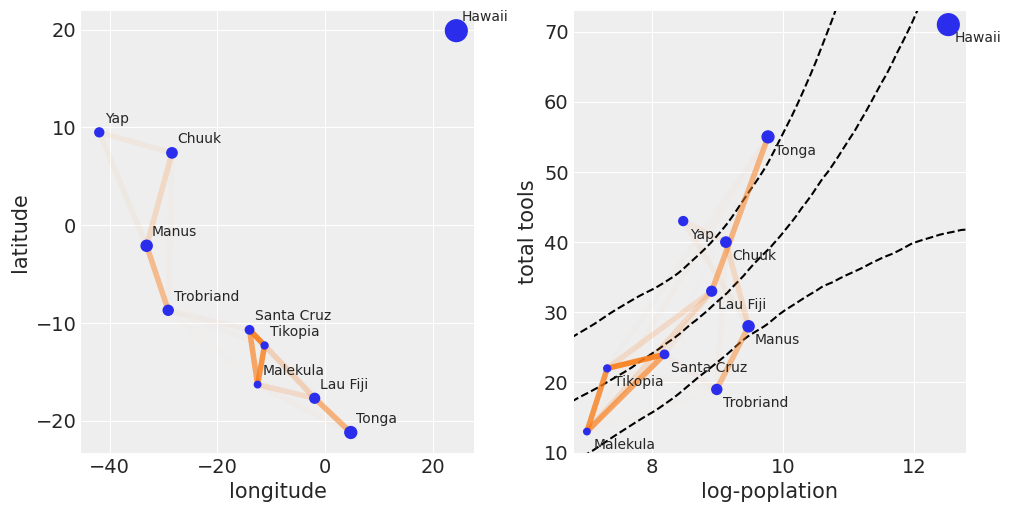

In [ ]:
α = trace_islands.posterior['α'].mean(axis=0)
β = trace_islands.posterior['β'].mean(axis=0)

logpop = np.copy(log_pop)
logpop /= logpop.max()
psize = np.exp(logpop * 5.5)
log_pop_seq = np.linspace(6, 14, 100)
lambda_post = np.exp(α.values[:, None] + β.values[:, None] * log_pop_seq)

_, axes = plt.subplots(1, 2, figsize=(10, 5),  constrained_layout=True)

ax = axes.flatten()

ax[0].scatter(islands['lon2'], islands['lat'], psize, zorder=3)
ax[1].scatter(islands['logpop'], islands['total_tools'], psize, zorder=3)

for i, itext in enumerate(culture_labels):
    ax[0].text(islands['lon2'][i] + 1, islands['lat'][i] + 1, itext)
    ax[1].text(islands['logpop'][i] + .1, islands['total_tools'][i] - 2.5,
               itext)

ax[1].plot(log_pop_seq, np.median(lambda_post, axis=0), 'k--')

az.plot_hdi(log_pop_seq,
            lambda_post,
            fill_kwargs={'alpha': 0},
            plot_kwargs={
                'color': 'k',
                'ls': '--',
                'alpha': 1
            })

for i in range(10):
    for j in np.arange(i + 1, 10):
        ax[0].plot((islands['lon2'][i], islands['lon2'][j]),
                   (islands['lat'][i], islands['lat'][j]),
                   'C1-',
                   alpha=ρ.iloc[i, j]**2,
                   lw=4)
        ax[1].plot((islands['logpop'][i], islands['logpop'][j]),
                   (islands['total_tools'][i], islands['total_tools'][j]),
                   'C1-',
                   alpha=ρ.iloc[i, j]**2,
                   lw=4)

ax[0].set(xlabel='longitude', ylabel='latitude')
ax[1].set(xlabel='log-poplation',
          ylabel='total tools',
          xlim=(6.8, 12.8),
          ylim=(10, 73))

# plt.savefig('images/ch13/gp_autocorr_locs.png')

### Gaussian process classification

In [ ]:
iris = pd.read_csv('../../datasets/stats/iris.csv')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [ ]:
df = iris.query("species == ('setosa', 'versicolor')")
y = pd.Categorical(df['species']).codes
x_1 = df['sepal_length'].values
X_1 = x_1[:, None]
X_1.shape

In [ ]:
with pm.Model() as model_iris:
    ℓ = pm.HalfCauchy("ℓ", 1)
    # ℓ = pm.Gamma('ℓ', 2, 0.5)
    cov = pm.gp.cov.ExpQuad(1, ℓ)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=X_1)
    # logistic inverse link function and Bernoulli likelihood
    y_ = pm.Bernoulli("y", p=pm.math.sigmoid(f), observed=y)
    trace_iris = pm.sample(1000,
                           chains=1,
                           compute_convergence_checks=False,
                           return_inferencedata=True)
    trace_iris.to_netcdf("data/ch13/gp_cls_iris.nc")
    # trace_iris = az.from_netcdf("../../datasets/pymc/ch13/gp_cls_iris.nc")

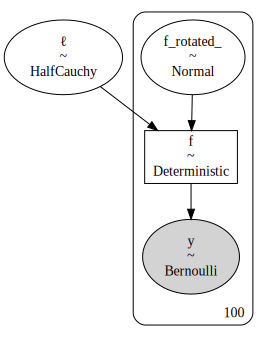

In [ ]:
pm.model_to_graphviz(model_iris)

In [ ]:
X_new = np.linspace(np.floor(x_1.min()), np.ceil(x_1.max()), 200)[:, None]

with model_iris:
    f_pred = gp.conditional('f_pred', X_new)
    pred_samples = pm.sample_posterior_predictive(trace_iris,
                                                  var_names=['f_pred'],
                                                  samples=1000)

LinAlgError: Matrix is not positive definite

In [ ]:
def find_midpoint(array1, array2, value):
    """
    This should be a proper docstring :-)
    """
    array1 = np.asarray(array1)
    idx0 = np.argsort(np.abs(array1 - value))[0]
    idx1 = idx0 - 1 if array1[idx0] > value else idx0 + 1
    if idx1 == len(array1):
        idx1 -= 1
    return (array2[idx0] + array2[idx1]) / 2

In [ ]:
from scipy.special import expit as logistic

ValueError: x and y must have same first dimension, but have shapes (200,) and (100,)

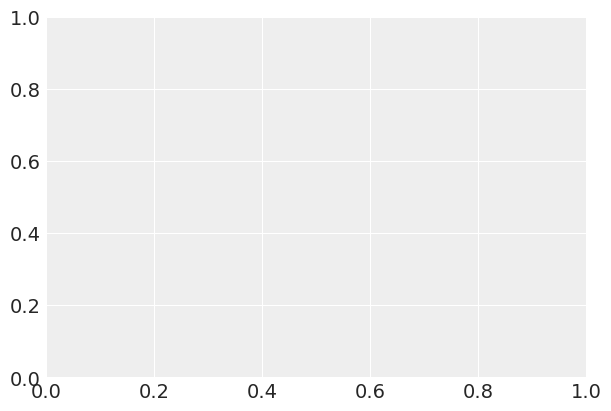

In [ ]:
fp = logistic(pred_samples['f_pred'])
fp_mean = np.mean(fp, 0)
db = np.array([find_midpoint(f, X_new[:, 0], 0.5) for f in fp])
db_mean = db.mean()
db_hpd = az.hdi(db)

_, ax = plt.subplots(figsize=(6, 4))

ax.plot(X_new[:, 0], fp_mean)
ax.scatter(x_1,
           np.random.normal(y, 0.02),
           marker='.',
           color=[f'C{x}' for x in y])

az.plot_hdi(X_new[:, 0], fp, color='C2')
ax.vlines(db_mean, 0, 1, color='k')
ax.fill_betweenx([0, 1], db_hpd[0], db_hpd[1], color='k', alpha=0.5)

ax.set(xlabel='sepal_length', ylabel='θ')
# plt.savefig('images/ch13/gp_log.png')

In [ ]:
with pm.Model() as model_iris2:
    #ℓ = pm.HalfCauchy("ℓ", 1)
    ℓ = pm.Gamma('ℓ', 2, 0.5)
    c = pm.Normal('c', x_1.min())
    τ = pm.HalfNormal('τ', 5)
    cov = (pm.gp.cov.ExpQuad(1, ℓ) +
           τ * pm.gp.cov.Linear(1, c) +
           pm.gp.cov.WhiteNoise(1E-5))
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=X_1)
    # logistic inverse link function and Bernoulli likelihood
    y_ = pm.Bernoulli("y", p=pm.math.sigmoid(f), observed=y)
#     trace_iris2 = pm.sample(1000, chains=1, compute_convergence_checks=False,
#                            return_inferencedata=True)
#     trace_iris2.to_netcdf("data/ch13/gp_cls_iris2.nc")
    trace_iris = az.from_netcdf("../../datasets/pymc/ch13/gp_cls_iris2.nc")

NameError: name 'x_1' is not defined

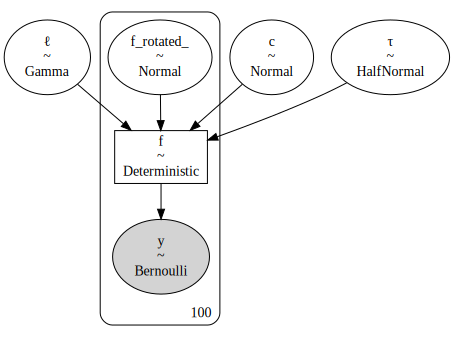

In [ ]:
pm.model_to_graphviz(model_iris2)

In [ ]:
with model_iris2:
    f_pred = gp.conditional('f_pred', X_new)
    pred_samples = pm.sample_posterior_predictive(trace_iris2,
                                                  vars=[f_pred],
                                                  samples=1000)

100%|██████████| 1000/1000 [00:23<00:00, 41.86it/s]


/usr/local/Caskroom/miniconda/base/envs/kaggle/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


[Text(0.5, 0, 'sepal_length'), Text(0, 0.5, 'θ')]

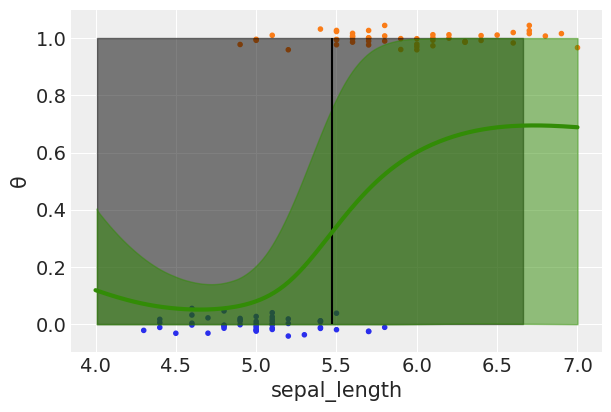

In [ ]:
fp = logistic(pred_samples['f_pred'])
fp_mean = np.mean(fp, 0)
db = np.array([find_midpoint(f, X_new[:, 0], 0.5) for f in fp])
db_mean = db.mean()
db_hpd = az.hdi(db)

_, ax = plt.subplots(figsize=(6, 4))

ax.scatter(x_1,
           np.random.normal(y, 0.02),
           marker='.',
           color=[f'C{ci}' for ci in y])
ax.vlines(db_mean, 0, 1, color='k')
ax.fill_betweenx([0, 1], db_hpd[0], db_hpd[1], color='k', alpha=0.5)

ax.plot(X_new[:, 0], fp_mean, 'C2', lw=3)
az.plot_hdi(X_new[:, 0], fp, color='C2')

ax.set(xlabel='sepal_length', ylabel='θ')

In [ ]:
flu = pd.read_csv('../data/space_flu.csv')
flu.head()

,age,space_flu
0,49,0
1,22,0
2,10,1
3,25,1
4,79,1


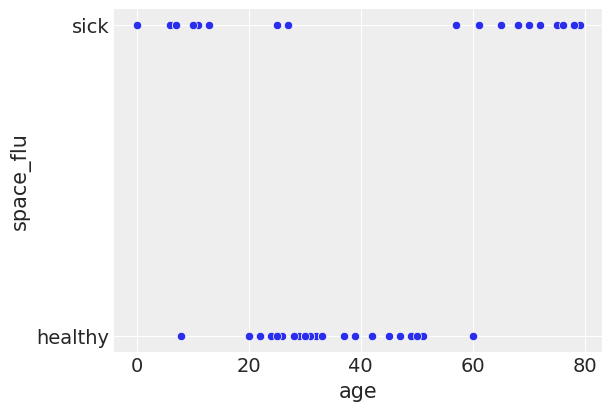

In [ ]:
age = flu.age.values[:, None]
space_flu = flu.space_flu

_, ax = plt.subplots(figsize=(6, 4))

ax.scatter(flu['age'], flu['space_flu'])
ax.set_yticks([0, 1])
ax.set_yticklabels(['healthy', 'sick'])
# plt.savefig('images/ch13/flu.png')

In [ ]:
with pm.Model() as model_space_flu:
    ℓ = pm.HalfCauchy('ℓ', 1)
    cov = pm.gp.cov.ExpQuad(1, ℓ) + pm.gp.cov.WhiteNoise(1E-5)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior('f', X=age)
    y_ = pm.Bernoulli('y', p=pm.math.sigmoid(f), observed=space_flu)
    # trace_space_flu = pm.sample(1000,
    #                             chains=1,
    #                             compute_convergence_checks=False,
    #                             return_inferencedata=True)
    # trace_space_flu.to_netcdf("data/ch13/gp_cls_flu.nc")
    trace_space_flu = az.from_netcdf("../../datasets/pymc/ch13/gp_cls_flu.nc")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [f_rotated_, ℓ]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 25 seconds.


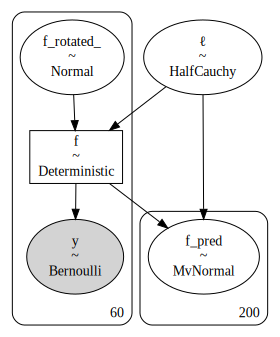

In [ ]:
pm.model_to_graphviz(model_space_flu)

In [ ]:
X_new = np.linspace(0, 80, 200)[:, None]

with model_space_flu:
    f_pred = gp.conditional('f_pred', X_new)
    pred_samples = pm.sample_posterior_predictive(trace_space_flu,
                                                  var_names=['f_pred'],
                                                  samples=1000)

/usr/local/Caskroom/miniconda/base/envs/kaggle/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


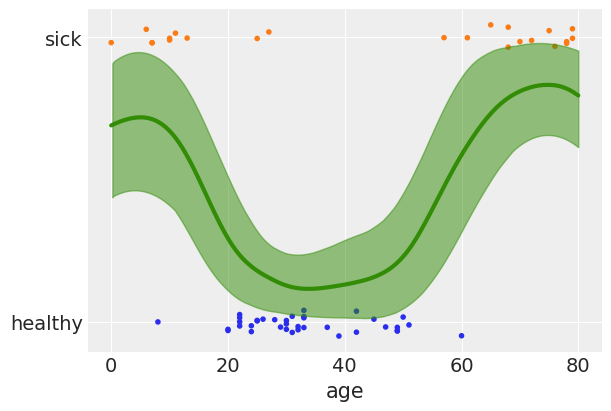

In [ ]:
_, ax = plt.subplots(figsize=(6, 4))

fp = logistic(pred_samples['f_pred'])
fp_mean = np.nanmean(fp, 0)

ax.scatter(age,
           np.random.normal(space_flu, 0.02),
           marker='.',
           color=[f'C{ci}' for ci in space_flu])

ax.plot(X_new[:, 0], fp_mean, 'C2', lw=3)

az.plot_hdi(X_new[:, 0], fp, color='C2')
ax.set_yticks([0, 1])
ax.set_yticklabels(['healthy', 'sick'])
ax.set_xlabel('age')
plt.savefig('images/ch13/flu_pred.png')

### the coal-mining disaster

In [ ]:
coal_df = pd.read_csv('../data/coal.csv', header=None)
coal_df.head()

,0
0,1851.2026
1,1851.6324
2,1851.9692
3,1851.9747
4,1852.3142


In [ ]:
# discretize data
years = int(coal_df.max().values - coal_df.min().values)
bins = years // 4
hist, x_edges = np.histogram(coal_df, bins=bins)
# compute the location of the centers of the discretized data
x_centers = x_edges[:-1] + (x_edges[1] - x_edges[0]) / 2
# arrange xdata into proper shape for GP
x_data = x_centers[:, None]
# express data as the rate number of disaster per year
y_data = hist / 4

In [ ]:
with pm.Model() as model_coal:
    ℓ = pm.HalfNormal('ℓ', x_data.std())
    cov = pm.gp.cov.ExpQuad(1, ls=ℓ) + pm.gp.cov.WhiteNoise(1E-5)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior('f', X=x_data)

    y_pred = pm.Poisson('y_pred', mu=pm.math.exp(f), observed=y_data)
    # trace_coal = pm.sample(1000, chains=1,
    #                             return_inferencedata=True)
    # trace_coal.to_netcdf("data/ch13/cox_coal.nc")
    trace_coal = az.from_netcdf("../../datasets/pymc/ch13/cox_coal.nc")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [f_rotated_, ℓ]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 37 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


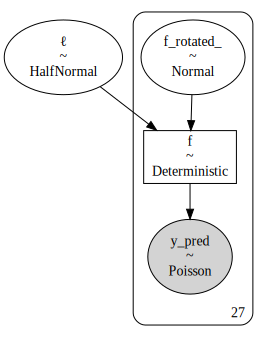

In [ ]:
pm.model_to_graphviz(model_coal)

/usr/local/Caskroom/miniconda/base/envs/kaggle/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/kaggle/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


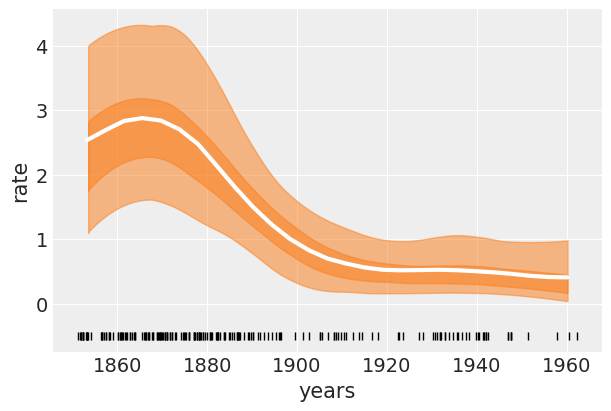

In [ ]:
f_trace = np.exp(trace_coal.posterior['f'].mean(axis=0))
rate_median = np.median(f_trace, axis=0)

_, ax = plt.subplots(figsize=(6, 4))

ax.plot(x_centers, rate_median, 'w', lw=3)
az.plot_hdi(x_centers, f_trace, ax=ax)

az.plot_hdi(x_centers, f_trace, hdi_prob=0.5, plot_kwargs={'alpha': 0}, ax=ax)

ax.plot(coal_df, np.zeros_like(coal_df) - 0.5, 'k|')
ax.set(xlabel='years', ylabel='rate')
# plt.savefig('images/ch13/coal_mine.png')

### the redwood data

In [ ]:
redwood = pd.read_csv('../data/redwood.csv', header=None)
redwood.head()

,0,1
0,0.931481,0.817680
1,0.938889,0.764273
2,0.935185,0.721915
3,0.979630,0.664825
4,0.787037,0.661142


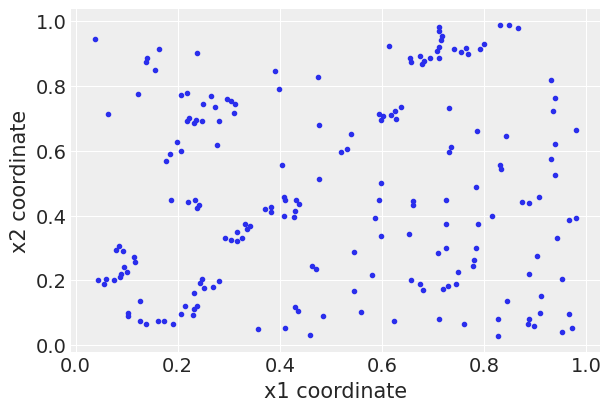

In [ ]:
_, ax = plt.subplots(figsize=(6, 4))

ax.plot(redwood[0], redwood[1], 'C0.')
ax.set(xlabel='x1 coordinate', ylabel='x2 coordinate')
# plt.savefig('images/ch13/redwood.png')

In [ ]:
# discretize spatial data
bins = 20
hist, x1_edges, x2_edges = np.histogram2d(
    redwood[1].values, redwood[0].values, bins=bins)
# compute the location of the centers of the discretized data
x1_centers = x1_edges[:-1] + (x1_edges[1] - x1_edges[0]) / 2
x2_centers = x2_edges[:-1] + (x2_edges[1] - x2_edges[0]) / 2
# arrange xdata into proper shape for GP
x_data = [x1_centers[:, None], x2_centers[:, None]]
# arrange ydata into proper shape for GP
y_data = hist.flatten()

In [ ]:
with pm.Model() as model_rw:
    ℓ = pm.HalfNormal('ℓ', redwood.std().values, shape=2)
    cov_func1 = pm.gp.cov.ExpQuad(1, ls=ℓ[0])
    cov_func2 = pm.gp.cov.ExpQuad(1, ls=ℓ[1])

    gp = pm.gp.LatentKron(cov_funcs=[cov_func1, cov_func2])
    f = gp.prior('f', Xs=x_data)

    y = pm.Poisson('y', mu=pm.math.exp(f), observed=y_data)
    trace_rw = pm.sample(1000, return_inferencedata=True)
    trace_rw.to_netcdf("data/ch13/cox_redwood.nc")
    # trace_rw = az.from_netcdf("../../datasets/pymc/ch13/cox_redwood.nc")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [f_rotated_, ℓ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 149 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


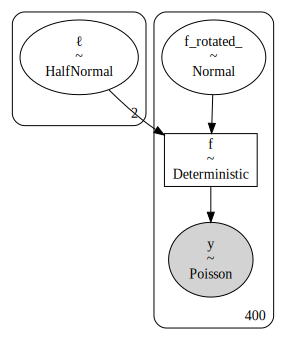

In [ ]:
pm.model_to_graphviz(model_rw)

In [ ]:
az.summary(trace_rw, var_names=['ℓ'])

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
ℓ[0],0.13,0.04,0.0,0.08,0.19,153.0,1.0
ℓ[1],0.09,0.03,0.0,0.05,0.14,217.0,1.0


In [ ]:
az.summary(trace_rw, var_names=['ℓ']).to_markdown()

'|      |   mean |    sd |   hdi_3% |   hdi_97% |   mcse_mean |   mcse_sd |   ess_bulk |   ess_tail |   r_hat |\n|:-----|-------:|------:|---------:|----------:|------------:|----------:|-----------:|-----------:|--------:|\n| ℓ[0] |  0.13  | 0.056 |    0.072 |     0.194 |       0.005 |     0.004 |        154 |        130 |    1.01 |\n| ℓ[1] |  0.095 | 0.024 |    0.055 |     0.137 |       0.002 |     0.001 |        154 |        298 |    1.01 |'

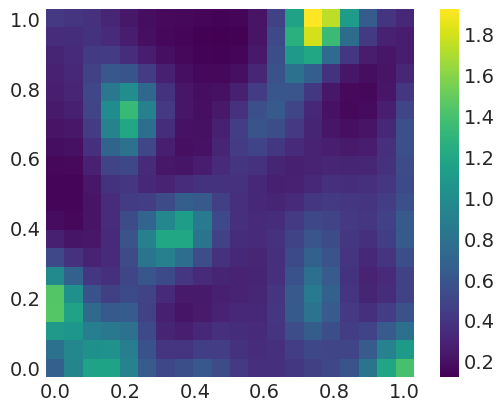

In [ ]:
bins = 20

f = trace_rw.posterior['f'].mean(axis=0)

rate = np.exp(f.mean(axis=0).to_numpy()).reshape((bins, -1))

fig, ax = plt.subplots(figsize=(6, 4))

ims = ax.imshow(rate, origin='lower')
ax.grid(False)
ticks_loc = np.linspace(0, bins - 1, 6)
ticks_lab = np.linspace(0, 1, 6).round(1)
ax.set(xticks=ticks_loc,
       yticks=ticks_loc,
       xticklabels=ticks_lab,
       yticklabels=ticks_lab)
cbar = fig.colorbar(ims, fraction=0.046, pad=0.04)
# plt.savefig('images/ch13/cox_redwood.png')